We review a physiological interpretation of consonance and dissonant musical sound for human listeners and use a dissonance score to rate different possible triads (combinations of three notes in a scale). This is first done on the conventional scale of 12 equidistant tones in an octave, as well as the Bohlen-Pierce scale.

In [10]:
using Plots
pyplot()

Plots.PyPlotBackend()

## Plomp-Levelt dissonance curve

As a basis of our investigation, we use the Plomp-Levelt dissonance curve as explained in [this article](http://sethares.engr.wisc.edu/consemi.html) by William Sethares.

In [58]:
"Dissonance of sound with two sinusoidal sounds with given frequencies and amplitudes."
function diss(freq1, ampl1, freq2, ampl2)
    if freq2 < freq1 # swap args
        return diss(freq2, ampl2, freq1, ampl1)
    end
    s = 0.24 * (freq2 - freq1) / (0.0207 * freq1 + 18.96)
    5.0 * ampl1 * ampl2 * (exp(-3.51 * s) - exp(-5.75 * s))
end

diss

In [87]:
basefreq = 440.0
ratrange = linspace(1.0, 3.0, 200)
otherfreq = basefreq * ratrange
disss = diss.(basefreq, 1.0, otherfreq, 1.0);


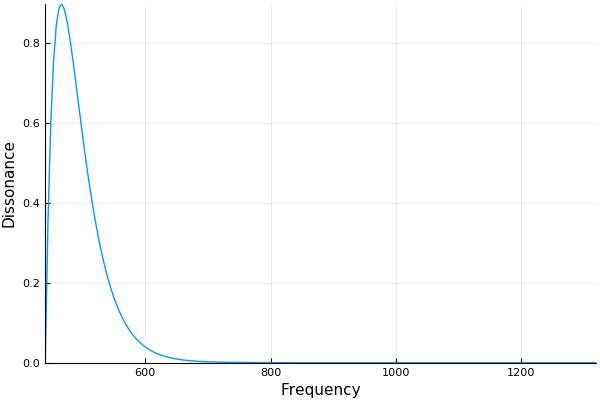

In [88]:
plot(otherfreq, disss, xlabel="Frequency", ylabel="Dissonance", legend=false)

## Dissonance with harmonics

Rather than analyzing dissonance between sinusoidal sounds, we also want to consider sounds with rich harmonics. These have sounds at multiple frequencies with declining amplitudes. When computing the dissonance between two pitches with harmonics, we have to add the dissonance values for all combinations of frequencies.

In [89]:
# Let's first give formulas for the amplitudes of common waveshapes.

enumrange(number::Int) = collect(linspace(1.0, number, number))

abstract type Wave end

type Sine <: Wave end
harm_ampl(::Sine, number::Int) = vcat([1.0], zeros(number - 1))

type Square <: Wave end
harm_ampl(::Square, number::Int) = 1.0 ./ enumrange(number) 

type Triangle <: Wave end
harm_ampl(::Triangle, number::Int) = 1.0 ./ enumrange(number).^2

harm_ampl (generic function with 3 methods)

In [90]:
@show harm_ampl(Sine(), 4)
@show harm_ampl(Square(), 4)
@show harm_ampl(Triangle(), 4);

harm_ampl(Sine(), 4) = [1.0, 0.0, 0.0, 0.0]
harm_ampl(Square(), 4) = [1.0, 0.5, 0.333333, 0.25]
harm_ampl(Triangle(), 4) = [1.0, 0.25, 0.111111, 0.0625]


In [91]:
# We add a new type to couple frequency and amplitute of a harmonic overtone

struct Tone
    freq::Float64
    ampl::Float64
end

diss(t1::Tone, t2::Tone) = diss(t1.freq, t1.ampl, t2.freq, t2.ampl)

diss (generic function with 4 methods)

In [92]:
# More functions to generate all overtones

function harmonics(wave::Wave, basefreq::Float64, number::Int)
    # frequencies with integer multiples
    freqs = basefreq .* enumrange(number)
    ampls = harm_ampl(wave, number)
    # keep tones with nonzero amplitude
    [Tone(tup...) for tup in zip(freqs, ampls) if tup[2] > 0.0]
end

harmonics (generic function with 1 method)

In [93]:
@show harmonics(Sine(), 440.0, 4)
@show harmonics(Triangle(), 440.0, 4);

harmonics(Sine(), 440.0, 4) = Tone[Tone(440.0, 1.0)]
harmonics(Triangle(), 440.0, 4) = Tone[Tone(440.0, 1.0), Tone(880.0, 0.25), Tone(1320.0, 0.111111), Tone(1760.0, 0.0625)]


In [94]:
function diss(tones::AbstractArray{Tone})
    res = 0.0
    # iterate over all pairs
    n = length(tones)
    for i = 1:n
        for j=i+1:n
            res += diss(tones[i], tones[j])
        end
    end
    res
end

diss (generic function with 4 methods)

In [95]:
function together(tones1::AbstractArray{Tone}, tones2::AbstractArray{Tone})
    # TODO: should do proper merge and match those tones with same frequency?
    vcat(tones1, tones2)
end

function diss(tones1::AbstractArray{Tone}, tones2::AbstractArray{Tone})
    diss(together(tones1, tones2))
end

diss (generic function with 4 methods)


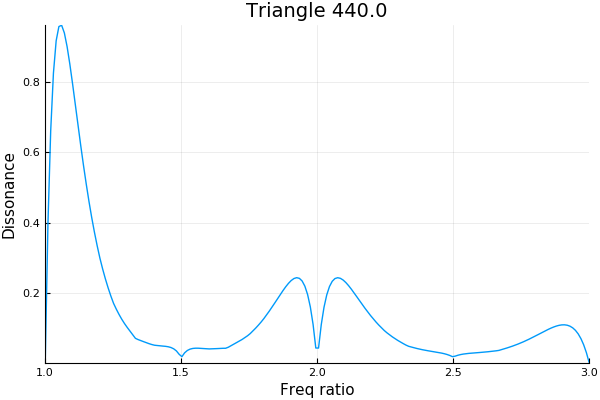

In [103]:
numharm = 10
basetone = harmonics(Triangle(), basefreq, numharm)
othertones = [harmonics(Triangle(), of, numharm) for of in otherfreq]
disss = [diss(basetone, ot) for ot in othertones]

plot(ratrange, disss, legend=false, xlabel="Freq ratio", ylabel="Dissonance", title="Triangle $basefreq")


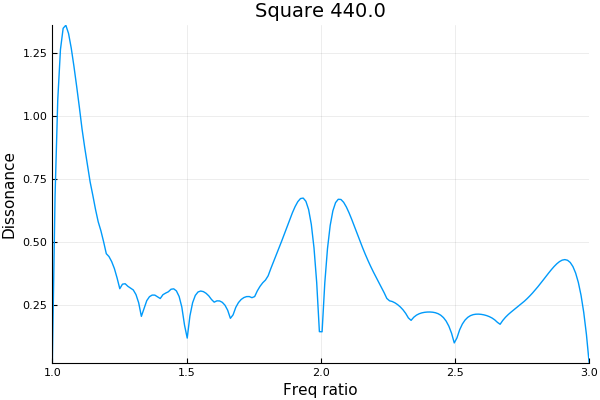

In [104]:
numharm = 10
basetone = harmonics(Square(), basefreq, numharm)
othertones = [harmonics(Square(), of, numharm) for of in otherfreq]
disss = [diss(basetone, ot) for ot in othertones]

plot(ratrange, disss, legend=false, xlabel="Freq ratio", ylabel="Dissonance", title="Square $basefreq")